# Mean-Variance Model

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
plt.style.use('ggplot')

In [2]:
stocks = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFC.NS', 'TATAMOTORS.NS', 'SUNPHARMA.NS', 'ONGC.NS', 'HINDUNILVR.NS', 'MARUTI.NS', 'TATASTEEL.NS']

In [3]:
df = yf.download(' '.join(stocks), start = '2022-01-01', end = '2022-02-01')

[*********************100%***********************]  10 of 10 completed


In [4]:
close =  df['Close']
close.head()

,HDFC.NS,HINDUNILVR.NS,INFY.NS,MARUTI.NS,ONGC.NS,RELIANCE.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS
Date,,,,,,,,,,
2022-01-03,2636.399902,2361.300049,1898.449951,7523.899902,143.050003,2403.850098,848.950012,497.600006,1142.449951,3817.750000
2022-01-04,2675.300049,2401.250000,1899.150024,7630.100098,147.800003,2458.100098,837.700012,489.600006,1148.800049,3884.750000
2022-01-05,2673.649902,2415.800049,1844.650024,7775.350098,150.350006,2469.600098,835.099976,489.750000,1177.599976,3860.949951
2022-01-06,2620.399902,2391.399902,1817.800049,7882.100098,150.800003,2416.500000,829.599976,488.850006,1163.250000,3807.449951
2022-01-07,2596.699951,2416.149902,1814.300049,7906.000000,157.050003,2436.000000,828.950012,490.600006,1160.349976,3853.500000


In [5]:
returns = close.pct_change()
returns.head()

,HDFC.NS,HINDUNILVR.NS,INFY.NS,MARUTI.NS,ONGC.NS,RELIANCE.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS
Date,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.014755,0.016919,0.000369,0.014115,0.033205,0.022568,-0.013252,-0.016077,0.005558,0.017550
2022-01-05,-0.000617,0.006059,-0.028697,0.019036,0.017253,0.004678,-0.003104,0.000306,0.025070,-0.006127
2022-01-06,-0.019917,-0.010100,-0.014556,0.013729,0.002993,-0.021501,-0.006586,-0.001838,-0.012186,-0.013857
2022-01-07,-0.009044,0.010350,-0.001925,0.003032,0.041446,0.008070,-0.000783,0.003580,-0.002493,0.012095


In [6]:
returns.dropna(axis = 0, inplace = True)

In [7]:
var_cov_matrix = returns.cov()
avg_returns = returns.mean()

In [8]:
var_cov_matrix

,HDFC.NS,HINDUNILVR.NS,INFY.NS,MARUTI.NS,ONGC.NS,RELIANCE.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS
HDFC.NS,0.000193,0.000116,0.000131,0.000056,0.000056,0.000147,0.000066,0.000082,0.000099,0.000108
HINDUNILVR.NS,0.000116,0.000215,0.000037,0.000140,0.000036,0.000116,0.000022,0.000022,0.000069,0.000101
INFY.NS,0.000131,0.000037,0.000324,-0.000035,0.000044,0.000181,0.000105,0.000203,0.000156,0.000195
MARUTI.NS,0.000056,0.000140,-0.000035,0.000558,0.000023,0.000063,-0.000033,0.000243,0.000137,-0.000018
ONGC.NS,0.000056,0.000036,0.000044,0.000023,0.000381,0.000136,0.000018,0.000150,0.000084,0.000052
RELIANCE.NS,0.000147,0.000116,0.000181,0.000063,0.000136,0.000259,0.000060,0.000184,0.000231,0.000137
SUNPHARMA.NS,0.000066,0.000022,0.000105,-0.000033,0.000018,0.000060,0.000171,0.000118,0.000167,0.000055
TATAMOTORS.NS,0.000082,0.000022,0.000203,0.000243,0.000150,0.000184,0.000118,0.000476,0.000353,0.000070
TATASTEEL.NS,0.000099,0.000069,0.000156,0.000137,0.000084,0.000231,0.000167,0.000353,0.000691,0.000098
TCS.NS,0.000108,0.000101,0.000195,-0.000018,0.000052,0.000137,0.000055,0.000070,0.000098,0.000227


In [9]:
def optimize(desired_return):
    mdl = Model(name = 'Mean-Variance')
    w = {(i): mdl.continuous_var(name = f'w_{i}', lb = 0, ub = 1) for i in returns.columns}
    w_vector = np.array(list(w.values()))
    mdl.minimize(np.matmul(np.matmul(w_vector.T,var_cov_matrix), w_vector))
    mdl.add_constraint(mdl.sum(w[i] for i in returns.columns) == 1)
    if desired_return:
        mdl.add_constraint(mdl.sum(np.matmul(avg_returns.values,w_vector)) >= desired_return)
    solution = mdl.solve()
    decision_vars = solution.get_value_dict(w, precision=1e-20)
    return np.array(list(decision_vars.values())), solution.objective_value

In [10]:
portfolios = []

In [11]:
#Desired Return
for desired_return in np.linspace(avg_returns[avg_returns>0].min(), avg_returns.max(), 10):
    decision_vars, obj = optimize(desired_return)
    actual_return = np.matmul(decision_vars,avg_returns)
    portfolios.append([np.sqrt(obj), actual_return])

In [12]:
#Global Minimum Variance
decision_vars, obj = optimize(False)
actual_return = np.matmul(decision_vars,avg_returns)
gmv = [np.sqrt(obj), actual_return]

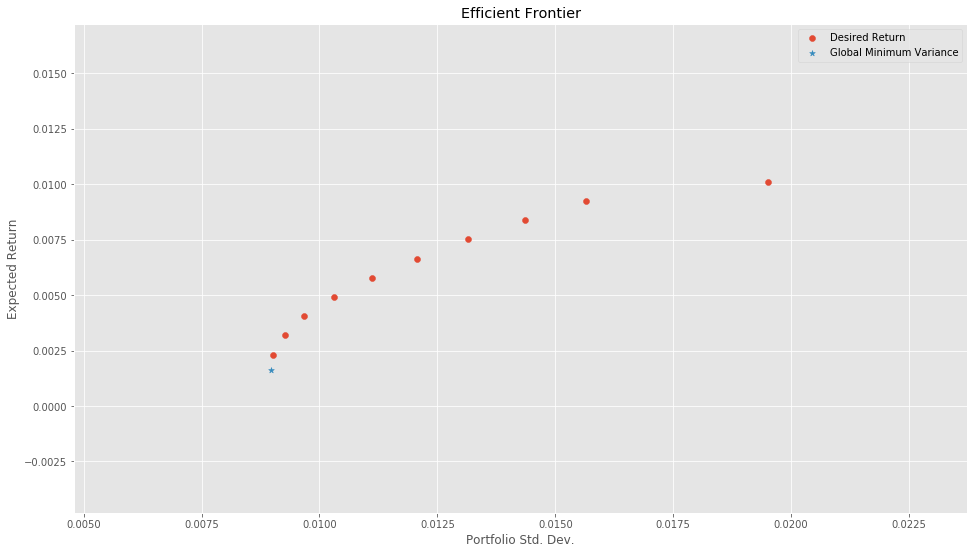

In [13]:
#Efficient Frontier Plot
plt.figure(figsize = (16, 9))
plt.scatter([x[0] for x in portfolios], [x[1] for x in portfolios], label = 'Desired Return')
plt.scatter(gmv[0], gmv[1], marker = '*', label = 'Global Minimum Variance')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Std. Dev.')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

<hr>